In [1]:
# ! pip install hyperopt
# ! pip install hyperas
import os
import sys
import time
# import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from IPython.display import display, clear_output

import hyperas
import hyperopt
from hyperas.distributions import uniform, choice
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperas import optim

os.chdir(os.getcwd())
# warnings.filterwarnings('ignore')

# Final Pre-Processing

In [2]:
train_data = pd.read_pickle(r"C:\Users\StanvanLoon\OneDrive - Umbrio B.V\Documents\GitHub\VU_ATM\assignment3\Data\tmtrain.Preprocessed.pickle")
dev_data = pd.read_pickle(r"C:\Users\StanvanLoon\OneDrive - Umbrio B.V\Documents\GitHub\VU_ATM\assignment3\Data\tmdev.Preprocessed.pickle")
train_data = pd.concat([train_data, dev_data])

In [3]:
features = ['Token_vector', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next_token_vector',
            'prev_token_vector', 'trigram_list_vectors', 'prev_bigram_list_vectors', 'next_bigram_list_vectors',
            'HECT', 'HECA']

In [4]:
train_y = train_data.Negation_cue.values
train_data = train_data[features]
len(train_data), len(train_data.columns)

(79018, 12)

In [5]:
categorical_features = ['POS', 'POS_TAG', 'Dependency_Label']
train_one_hot_features = pd.get_dummies(train_data[categorical_features]).values

In [6]:
def multiply_vectors(vectors):
    result = [[1]*len(vectors[0])]
    for vector in vectors: result *= vector
    return result[0]
    
def extract_vectors(row):
    result = list(row.Token_vector)
    result.extend(row.next_token_vector)
    result.extend(row.prev_token_vector)
    result.append(row.HECT)
    result.append(row.HECA)
    result.append(row.Dependency_Head)
    result.extend(multiply_vectors(row.trigram_list_vectors))
    result.extend(multiply_vectors(row.prev_bigram_list_vectors))
    result.extend(multiply_vectors(row.next_bigram_list_vectors))
    
    return result

In [7]:
train_x = []
for i in range(len(train_data)):
    train_x.append(np.append(train_one_hot_features[i], extract_vectors(train_data.iloc[i])))

In [8]:
len(train_x), len(train_x[0])

(79018, 1904)

# SVM example

In [9]:
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler

svm = pipeline.make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(train_x[:1000], train_y[:1000])
pipeline.Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

### Prediction using train data as example

In [10]:
%%time
prediction = svm.predict(train_x)
f1_score(train_y, prediction, average='weighted')

Wall time: 1min 1s


0.9803877777801614

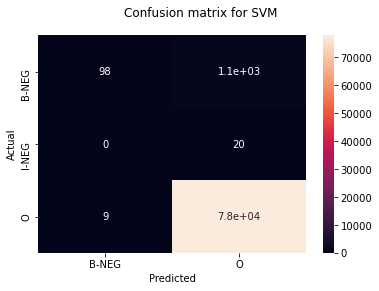

In [11]:
import seaborn as sns

confusion_matrix = pd.crosstab(pd.DataFrame(train_y)[0], pd.DataFrame(prediction)[0], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.suptitle('Confusion matrix for SVM')
plt.show()

# Feature Ablation Study

# HyperOpt

In [12]:
space = {'C': hp.uniform('C', 0.01, 5), # Gives the upper an lower limit
         'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf']), # HyperOpt has to choose one
         'gamma': hp.choice('gamma', ['scale', 'auto'])} # HyperOpt has to choose one

def optimizer(space):
    
    svm = SVC(C=space['C'],
              kernel=space['kernel'],
              gamma=space['gamma'])
    
    svm.fit(train_x[:100], train_y[:100])
    
    prediction = svm.predict(train_x[:100])
    F1_score = f1_score(train_y[:100], prediction, average='weighted')
    
    return {'loss': -F1_score, 'status': STATUS_OK}

SVM_trails = Trials()

SVM_best = fmin(fn=optimizer,
                space=space,
                algo=tpe.suggest,
                max_evals=2, # Set to a 100 or so for the final run when u know everything is working
                trials=SVM_trails)
SVM_best

100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 61.04trial/s, best loss: -1.0]


{'C': 4.889373872966958, 'gamma': 0, 'kernel': 0}

In [13]:
SVM_best = hyperopt.space_eval(space, SVM_best)
SVM_best

{'C': 4.889373872966958, 'gamma': 'scale', 'kernel': 'linear'}

In [14]:
svm = SVC(C=SVM_best['C'],
          kernel=SVM_best['kernel'],
          gamma=SVM_best['gamma'])

svm.fit(train_x[:100], train_y[:100])

prediction = svm.predict(train_x[:100])
f1_score(train_y[:100], prediction, average='weighted')

1.0

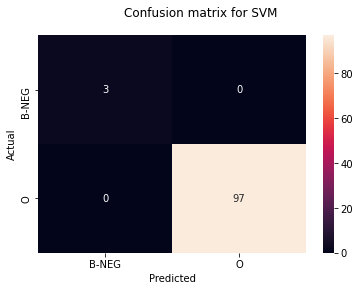

In [15]:
confusion_matrix = pd.crosstab(pd.DataFrame(train_y[:100])[0], pd.DataFrame(prediction)[0], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.suptitle('Confusion matrix for SVM')
plt.savefig('CM_SVM.pdf')
plt.show()

# Results on the test data